In [1]:
#@title Imports and Global Variables (make sure to run this cell)  { display-mode: "form" }

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
      pass


from __future__ import absolute_import, division, print_function


#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

    
#M.S.> had to uninstall numpy via pip and reinstall via conda (v.1.18.5)
import numpy as np
import pandas as pd
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/)
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
#%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
#%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=False):
    """
    Allowing the notebook to make use of GPUs if they're available.

    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear
    algebra that optimizes TensorFlow computations.
    """
    config = tf.config
    gpu_devices = config.experimental.list_physical_devices('GPU')
    if enable_gpu_ram_resizing:
        for device in gpu_devices:
            tf.config.experimental.set_memory_growth(device, True)
    if enable_xla:
        config.optimizer.set_jit(True)
    return config

session_options(enable_gpu_ram_resizing=True, enable_xla=True)

<module 'tensorflow._api.v2.config' from 'C:\\Users\\maris\\anaconda3\\envs\\tfp-env\\lib\\site-packages\\tensorflow\\_api\\v2\\config\\__init__.py'>

In [2]:
#read CSV data and convert to Pandas Dataframe for column exctraction, then check type.
g2_data = pd.read_csv('C:/Users/maris/Documents/QC_Modeling_Bayesian/newfittingfunctionparametersstagepositiosn/20200611_Cross_g2_ExpData_stage1.csv', 
                      usecols=['photon_spacing', 'g2'])
# print(g2_data.head())
g2_array = np.array(g2_data['g2'])
time_array = np.arange(0,100,1)


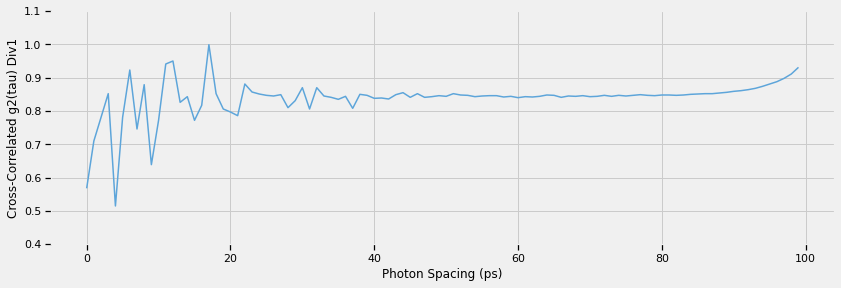

In [3]:
# Defining our Data into tensor array for TFP from Pd.Array type
# # Visualizing the Results as a check 
plt.figure(figsize=(12.5, 4))
plt.plot(time_array, g2_array, color="#5DA5DA")
#Arbitary x-label to match Andrews 20201031 MatLab axes
plt.xlabel("Photon Spacing (ps)")
plt.ylabel("Cross-Correlated g2(tau) Div1")
# plt.xlim(10e5, 1e12);
plt.ylim(0.4, 1.1);

In [4]:
def func(x, a1, a2, t1, t2, t01, t02, c):
    
    
    return -a1 * np.exp(-t1 * (x-t01)) + a2 * np.exp(+t2 * (x-t02)) + c

In [6]:
# wrap the mcmc sampling call in a @tf.function to speed it up
@tf.function(autograph=False)
def graph_sample_chain(*args, **kwargs):
    return tfp.mcmc.sample_chain(*args, **kwargs)

num_burnin_steps = 5000
(num_results) = 20000


# Set the chain's start state.
initial_chain_state = [
    tf.cast(tf.reduce_mean(g2_array), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda1"),
    tf.cast(tf.reduce_mean(g2_array), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda2"),
    0.5 * tf.ones([], dtype=tf.float32, name="init_tau"),
]


# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Sigmoid(),   # Maps [0,1] to R.  
]

step_size = 0.2

kernel=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_log_posterior,
            num_leapfrog_steps=2,
            step_size=step_size,
            state_gradients_are_stopped=True),
        bijector=unconstraining_bijectors)

kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=kernel, num_adaptation_steps=int(num_burnin_steps * 0.8))


# Sample from the chain.
[
    lambda_1_samples,
    lambda_2_samples,
    posterior_tau,
], kernel_results = graph_sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=initial_chain_state,
    kernel = kernel)
    
tau_samples = tf.floor(posterior_tau * tf.cast(tf.size(count_data),dtype=tf.float32))

NameError: name 'unnormalized_log_posterior' is not defined